## RANSAC regression algorithm for differentiating outliers for a better model

### Load libraries and data

In [70]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import DBSCAN, HDBSCAN
# Import plotyly
import plotly.express as px

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

### Functions to test this data

In [71]:
# Robustly fit linear model with RANSAC algorithm
def ransac_linear(X_train, y_train, X_test, y_test, data_df=pd.DataFrame(), seed=None):
    ransac = RANSACRegressor(max_trials=500, min_samples=30000, loss='squared_error')

    if seed is not None:
        ransac = RANSACRegressor(random_state=seed, max_trials=500, min_samples=30000, loss='squared_error')
    
    ransac.fit(X_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_pred = ransac.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred)
    r2_train = ransac.score(X_train, y_train)

    # print(f"Mean Squared Error Train: {mse_train}")
    # print(f"R-squared Train: {r2_train}")

    y_pred = ransac.predict(X_test)

    # Evaluating the model
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = ransac.score(X_test, y_test)

    # print(f"Mean Squared Error Test: {mse_test}")
    # print(f"R-squared Test: {r2_test}")
    outlier_count = -1
    if not data_df.empty:
        outlier_mask = np.logical_not(ransac.inlier_mask_)
        data_df['Is_Outlier'] = outlier_mask
        outlier_count = data_df[data_df['Is_Outlier'] == True].shape[0]
    else: 
        print("The dataframe you passed in was empty.")
    
    print("Outlier count: ", outlier_count)

    return mse_train, mse_test, r2_train, r2_test, data_df, outlier_count, ransac.estimator_.coef_

def run_several_ransac_linear(n_to_run, X_train, y_train, X_test, y_test, data_df=pd.DataFrame()):
    mse_trains = []
    mse_tests = []
    r2_trains = []
    r2_tests = []
    outlier_count = []
    if data_df.empty:
        print("Warning -- the dataframe is empty.")
    for x in range(n_to_run):
        results = ransac_linear(X_train, y_train, X_test, y_test, data_df, x)
        mse_trains.append(results[0])
        mse_tests.append(results[1])
        r2_trains.append(results[2])
        r2_tests.append(results[3])
        outlier_count.append(results[5])


    print(r2_tests)
    print(outlier_count)
    print("")
    print("Mean MSE Train: ", sum(mse_trains)/len(mse_trains))
    print("Mean R2 Train: ", sum(r2_trains)/len(r2_trains))
    print("Mean MSE Test: ", sum(mse_tests)/len(mse_tests))
    print("Mean R2 Test: ", sum(r2_tests)/len(r2_tests))

### Load Data

In [72]:
data = pd.read_csv("all_data.csv", index_col=0)
data.drop(columns=['Date'], inplace=True)
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)
print(data.shape)
mask = ~data['Year'].isin([2008, 2012])
data = data[mask]
data.head()

(596366, 18)


,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0,06
1,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1,06
2,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0,17
3,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1,17
4,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0,48


In [73]:
# Loading the shapefile in order to visualize clean data on the US map
def merge_dfs(us_counties, data):
    data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
    return data

us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merge_dfs(us_counties, data)
print(merged_data.columns)
merged_data.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Year', 'Month',
       'RegionName', 'State', 'Bottom-Tier Average Home Value Estimate',
       'Top-Tier Average Home Value Estimate', 'Average Temperature Value',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'StateAbbrv',
       'Initial Fees and Charges (%)', 'Effective Rate (%)',
       'Term to Maturity', 'Loan Amount ($thou)', 'Purchase Price ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'StateFPS'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.93,8.01,15,103.0,173.6,64.7,7.0,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.81,8.20,30,129.9,166.8,81.1,61.1,31
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.91,8.18,15,100.5,172.8,63.1,7.2,31
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.78,8.39,30,127.8,163.7,81.2,58.6,31
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,38.0,NE,0.87,8.24,15,101.2,176.9,62.7,7.2,31


In [74]:
def split_train_test(data):
   # data.drop(columns=['RegionName', 'State','StateFPS', 'StateAbbrv'], inplace=True)
    test = data[data['Year'] == 2019].copy()
    train = data[data['Year'] != 2019].copy()
    return train, test

def scale_train_test(train, test):
    columns_to_scale = train.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 
                                           'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
                        'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).columns

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler to the specified columns
    scaler.fit(train[columns_to_scale])

    # Transform the train using the fitted scaler and convert it back to a trainFrame
    scaled_train = scaler.transform(train[columns_to_scale])
    scaled_train = pd.DataFrame(scaled_train, columns=columns_to_scale, index=train.index)
    scaled_train['Year'] = train['Year']
    scaled_train['Month'] = train['Month']
    scaled_train['RegionName'] = train['RegionName']
    scaled_train['State'] = train['State']
    scaled_train['StateFPS'] = train['StateFPS']
    scaled_train['StateAbbrv'] = train['StateAbbrv']

    scaled_test = scaler.transform(test[columns_to_scale])
    scaled_test = pd.DataFrame(scaled_test, columns=columns_to_scale, index=test.index)
    scaled_test['Year'] = test['Year']
    scaled_test['Month'] = test['Month']
    scaled_test['RegionName'] = test['RegionName']
    scaled_test['State'] = test['State']
    scaled_test['StateFPS'] = test['StateFPS']
    scaled_test['StateAbbrv'] = test['StateAbbrv']

    return scaled_train, scaled_test

def split_X_Y(train, test):
    X_train = train.drop(columns=['Purchase Price ($thou)', 'RegionName', 'State', 'StateFPS', 'StateAbbrv'])
    y_train = train['Purchase Price ($thou)'].copy()
    X_test = test.drop(columns=['Purchase Price ($thou)', 'RegionName', 'State', 'StateFPS', 'StateAbbrv'])
    y_test = test['Purchase Price ($thou)'].copy()
    return X_train, y_train, X_test, y_test

def select_features(train, test):
    train = train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
    test = test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
    return train, test

In [75]:
train, test = split_train_test(merged_data)
train_scaled, test_scaled = scale_train_test(train, test)
train_selected, test_selected = select_features(train_scaled, test_scaled)
print(train_selected.columns)
train_selected.head()

Index(['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)',
       '1901-2000 Mean', 'Effective Rate (%)', 'Loan Amount ($thou)',
       'Purchase Price ($thou)', 'Loan-to-Price Ratio (%)',
       'Share of Total Market (%)', 'RegionName', 'State', 'StateFPS',
       'StateAbbrv'],
      dtype='object')


,Year,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),RegionName,State,StateFPS,StateAbbrv
0,2000,0.323972,0.619597,0.226919,0.904425,0.088942,0.240194,0.524051,0.073077,Lancaster County,NE,31,NE
1,2000,0.323972,0.619597,0.226919,0.938053,0.250601,0.207264,0.939241,0.766667,Lancaster County,NE,31,NE
2,2000,0.403210,0.700288,0.283648,0.934513,0.073918,0.236320,0.483544,0.075641,Lancaster County,NE,31,NE
3,2000,0.403210,0.700288,0.283648,0.971681,0.237981,0.192252,0.941772,0.734615,Lancaster County,NE,31,NE
4,2000,0.481444,0.616715,0.402670,0.945133,0.078125,0.256174,0.473418,0.075641,Lancaster County,NE,31,NE


In [76]:
scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test = split_X_Y(train_selected, test_selected)
print(scaled_X_train.columns)
scaled_X_train.head()

Index(['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)',
       '1901-2000 Mean', 'Effective Rate (%)', 'Loan Amount ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)'],
      dtype='object')


,Year,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000,0.323972,0.619597,0.226919,0.904425,0.088942,0.524051,0.073077
1,2000,0.323972,0.619597,0.226919,0.938053,0.250601,0.939241,0.766667
2,2000,0.403210,0.700288,0.283648,0.934513,0.073918,0.483544,0.075641
3,2000,0.403210,0.700288,0.283648,0.971681,0.237981,0.941772,0.734615
4,2000,0.481444,0.616715,0.402670,0.945133,0.078125,0.473418,0.075641


In [77]:
scaled_X_train.describe()

,Year,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
count,504352.000000,504352.000000,504352.000000,504352.000000,504352.000000,504352.000000,504352.000000,504352.000000
mean,2010.524114,0.596246,0.467036,0.587768,0.372351,0.527482,0.722733,0.460235
std,5.538307,0.172176,0.096826,0.189822,0.219985,0.223045,0.215919,0.372599
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,0.467402,0.409222,0.442714,0.207080,0.364183,0.584810,0.082051
50%,2011.000000,0.613842,0.466859,0.604004,0.316814,0.536058,0.779747,0.399359
75%,2015.000000,0.739218,0.524496,0.748610,0.543363,0.678486,0.924051,0.823077
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## For county, let's do a linear regression of temperature anomaly and housing prices

In [78]:
def linear_regression_temp_purch_price(data):
    model = LinearRegression()
    X = data['Anomaly (1901-2000 base period)'].values.reshape(-1, 1)
    y = data['Purchase Price ($thou)'].values

    model.fit(X, y)

    y_pred = model.predict(X)

    # Calculate R-squared and MSE
    r_squared = model.score(X, y)
    mse = mean_squared_error(y, y_pred)

    return pd.Series({
        'R_squared': r_squared,
        'MSE': mse,
        'Slope': model.coef_[0],
        'Intercept': model.intercept_
    })

train_regression_results = train_selected.groupby(['RegionName', 'State']).apply(linear_regression_temp_purch_price).reset_index()
train_regression_results.head()

C:\Users\quint\AppData\Local\Temp\ipykernel_28564\1671439118.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_regression_results = train_selected.groupby(['RegionName', 'State']).apply(linear_regression_temp_purch_price).reset_index()


,RegionName,State,R_squared,MSE,Slope,Intercept
0,Acadia Parish,LA,0.000893,0.004977,-0.022373,0.840530
1,Ada County,ID,0.006864,0.025418,0.151530,0.563901
2,Adair County,MO,0.053982,0.007239,0.165976,0.712812
3,Adams County,CO,0.001388,0.031790,0.073918,0.576994
4,Adams County,IL,0.009725,0.023774,0.131391,0.650716


In [79]:
train_regression_results.sort_values(by='R_squared', ascending=False).head()

,RegionName,State,R_squared,MSE,Slope,Intercept
1027,Meade County,SD,0.169284,0.004245,-0.214822,0.949624
335,Codington County,SD,0.140592,0.004390,-0.201481,0.941189
1372,Santa Barbara County,CA,0.128635,0.027739,0.981986,0.121887
871,Lauderdale County,MS,0.127520,0.006676,0.316995,0.641452
1443,Stanley County,SD,0.127404,0.004459,-0.189471,0.937162


In [80]:
train_regression_results.sort_values(by='MSE', ascending=True).head()

,RegionName,State,R_squared,MSE,Slope,Intercept
1235,Phillips County,AR,0.019747,0.003518,-0.084309,0.910578
631,Hale County,AL,0.002595,0.003579,-0.031806,0.885878
1016,McHenry County,ND,0.001155,0.003585,-0.016690,0.878929
1027,Meade County,SD,0.169284,0.004245,-0.214822,0.949624
335,Codington County,SD,0.140592,0.004390,-0.201481,0.941189


<Axes: xlabel='MSE', ylabel='R_squared'>

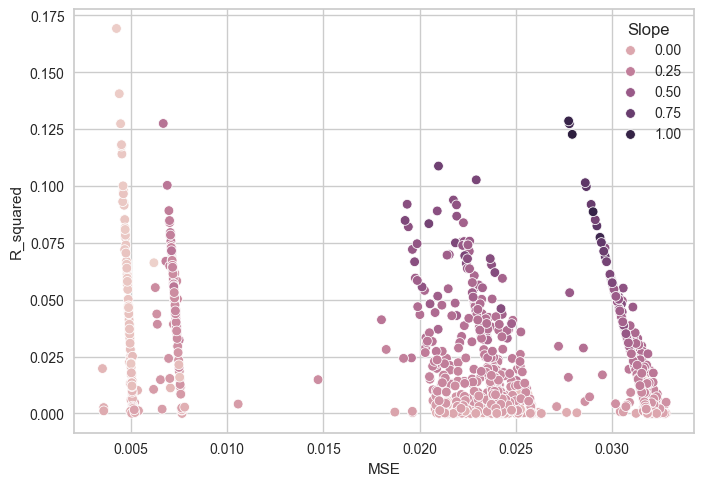

In [81]:
sns.scatterplot(train_regression_results, x='MSE', y='R_squared', hue='Slope')

<Axes: xlabel='R_squared', ylabel='Count'>

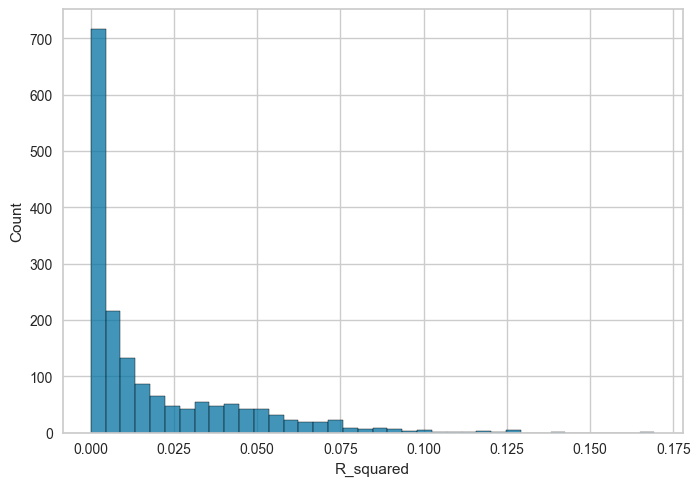

In [82]:
sns.histplot(train_regression_results, x='R_squared')

<Axes: xlabel='MSE', ylabel='Count'>

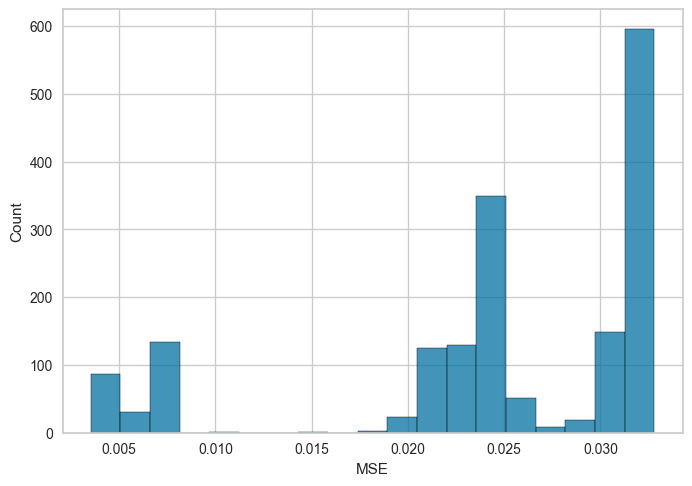

In [83]:
sns.histplot(train_regression_results, x='MSE')

In [84]:
train_regression_results['StateFPS'] = train_regression_results['State'].map(state_to_fips)
train_regression_merged = merge_dfs(us_counties, train_regression_results)
train_regression_merged.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,INTPTLAT,INTPTLON,geometry,RegionName,State,R_squared,MSE,Slope,Intercept,StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",Lancaster County,NE,0.001487,0.031787,-0.062124,0.641261,31
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,+43.6674723,-096.7957261,"POLYGON ((-96.60910 43.50043, -96.61070 43.500...",Minnehaha County,SD,0.005663,0.022373,0.096920,0.652315,46
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,None,...,+41.0002170,-083.6659471,"POLYGON ((-83.61191 41.16739, -83.60513 41.167...",Hancock County,OH,0.001752,0.031779,0.067206,0.580669,39
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,None,...,+34.0684364,-101.8228879,"POLYGON ((-102.09041 34.31313, -102.08890 34.3...",Hale County,TX,0.000029,0.024126,0.010457,0.705212,48
4,48,011,01383791,48011,Armstrong,Armstrong County,06,H1,G4020,None,...,+34.9641790,-101.3566363,"POLYGON ((-101.62512 35.00070, -101.62509 35.0...",Armstrong County,TX,0.040388,0.007343,0.216896,0.684136,48


<Axes: >

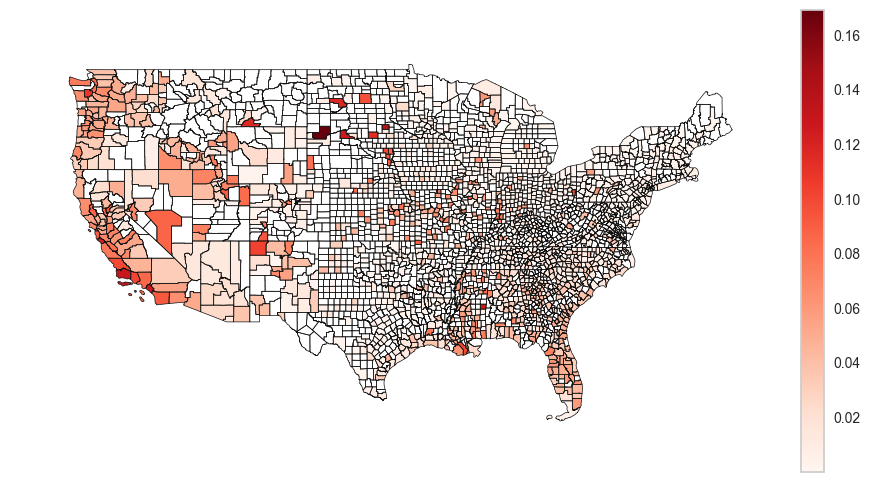

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='R_squared', ax=ax, cmap='Reds', legend=True)

<Axes: >

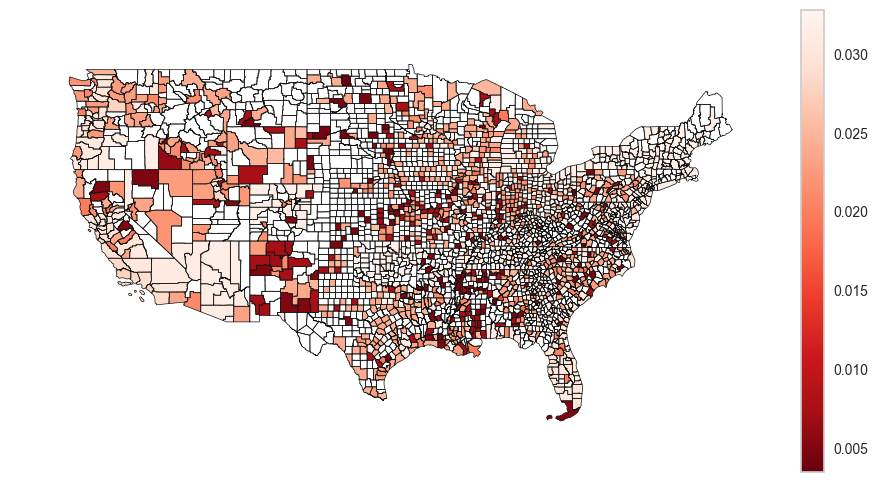

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='MSE', ax=ax, cmap='Reds_r', legend=True)

<Axes: >

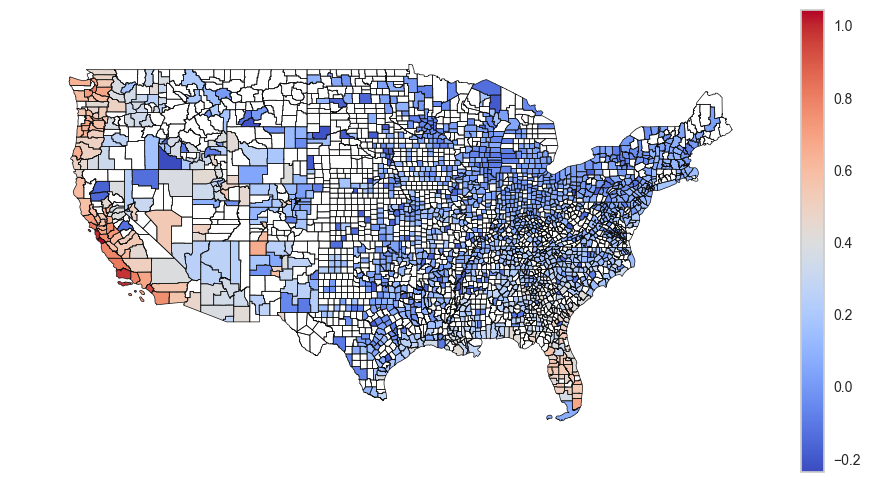

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='Slope', ax=ax, cmap='coolwarm', legend=True)

### Run the RANSAC model 

Here's the original data from the previous notebook but with this better scaling (the MinMax).

In [88]:
run_several_ransac_linear(3, scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test, train_scaled)

Outlier count:  0
Outlier count:  0
Outlier count:  0
[0.8075796380015123, 0.8075796380015123, 0.8075796380015123]
[0, 0, 0]

Mean MSE Train:  0.0007965599168276308
Mean R2 Train:  0.9742285351076742
Mean MSE Test:  0.0004463223316250557
Mean R2 Test:  0.8075796380015122


In [89]:
results = ransac_linear(scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test, train_scaled)

Outlier count:  0


## DBSCAN on the Regression Values

Clusters
 1    1431
 0     236
-1      36
Name: count, dtype: int64

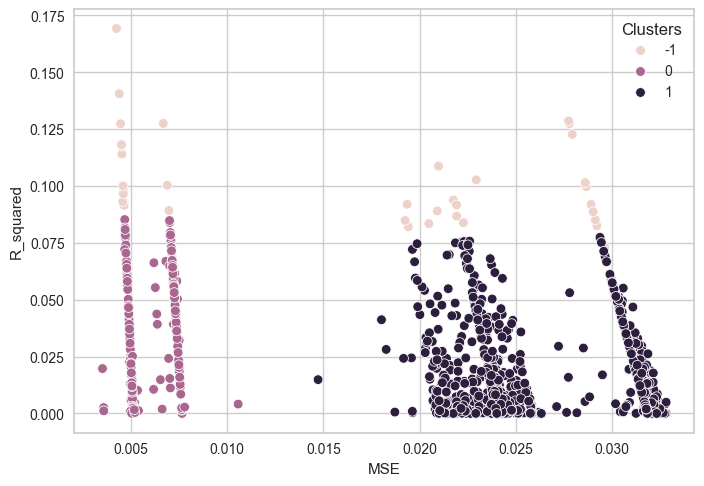

In [90]:
X = train_regression_results.drop(columns=['RegionName', 'State', 'StateFPS', 'Slope', 'Intercept'])

# Tuned by hand                                           
dbscan = DBSCAN(eps=0.007, min_samples=15)
dbscan.fit(X)
train_regression_results['Clusters'] = dbscan.labels_
sns.scatterplot(data=train_regression_results, x='MSE', y='R_squared', hue='Clusters')
train_regression_results['Clusters'].value_counts()

In [91]:
cluster_names = {
    -1: 'High R2/Outliers',  # Typically, -1 in DBSCAN are outliers
    0: 'Low MSE',  # A meaningful name based on what you found in cluster 0
    1: 'High MSE'   # A meaningful name based on what you found in cluster 1
}

# Rename the clusters
train_regression_results['Clusters'] = train_regression_results['Clusters'].map(cluster_names)
cluster_dummies = pd.get_dummies(train_regression_results['Clusters'], drop_first=True)

# Optional: drop the original 'Clusters' column if no longer needed
train_regression_results = train_regression_results.drop(columns=['Clusters'])

# Join the one-hot encoded columns back to the original DataFrame
train_regression_results_encoded = pd.concat([train_regression_results, cluster_dummies], axis=1)

# Show the updated DataFrame
train_regression_results_encoded

,RegionName,State,R_squared,MSE,Slope,Intercept,StateFPS,High R2/Outliers,Low MSE
0,Acadia Parish,LA,0.000893,0.004977,-0.022373,0.840530,22,False,True
1,Ada County,ID,0.006864,0.025418,0.151530,0.563901,16,False,False
2,Adair County,MO,0.053982,0.007239,0.165976,0.712812,29,False,True
3,Adams County,CO,0.001388,0.031790,0.073918,0.576994,08,False,False
4,Adams County,IL,0.009725,0.023774,0.131391,0.650716,17,False,False
...,...,...,...,...,...,...,...,...,...
1698,York County,PA,0.001960,0.031772,0.085729,0.570842,42,False,False
1699,York County,SC,0.015888,0.027728,0.249751,0.509889,45,False,False
1700,York County,VA,0.005598,0.021011,0.124530,0.607335,51,False,False
1701,Yuba County,CA,0.092003,0.019349,0.587349,0.406627,06,True,False


<Axes: >

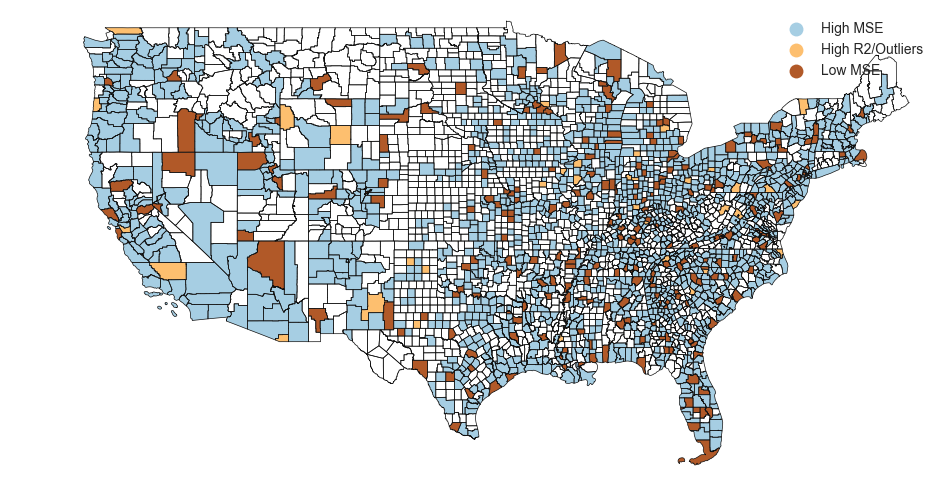

In [94]:
train_regression_merged['Clusters'] = dbscan.labels_
train_regression_merged['Clusters'] = train_regression_merged['Clusters'].map(cluster_names)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='Clusters', ax=ax, cmap='Paired', legend=True)

In [99]:
data_selected_scaled_encoded = train_selected.merge(train_regression_results_encoded[['High R2/Outliers', 'Low MSE', 'State', 'RegionName']], on=['RegionName', 'State'])
data_selected_scaled_encoded.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv'], inplace=True)

,Year,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),High R2/Outliers,Low MSE
1278,2013,0.424273,0.498559,0.384872,0.000000,0.509615,0.803874,0.602532,0.169231,False,True
1279,2013,0.424273,0.498559,0.384872,0.136283,0.705529,0.710896,0.903797,0.802564,False,True
1280,2013,0.441324,0.432277,0.429366,0.014159,0.536058,0.766586,0.658228,0.169231,False,True
1281,2013,0.441324,0.432277,0.429366,0.152212,0.706731,0.692978,0.918987,0.788462,False,True
1282,2013,0.539619,0.504323,0.510567,0.033628,0.534856,0.776755,0.640506,0.150000,False,True
...,...,...,...,...,...,...,...,...,...,...,...
503943,2018,0.662989,0.368876,0.699666,0.366372,0.903245,0.878450,0.918987,0.887179,False,True
503944,2018,0.519559,0.308357,0.563960,0.276106,0.634014,0.861501,0.564557,0.058974,False,True
503945,2018,0.519559,0.308357,0.563960,0.384071,0.931490,0.898305,0.929114,0.882051,False,True
503946,2018,0.478435,0.426513,0.472747,0.286726,0.701923,0.993705,0.546835,0.060256,False,True
